note: multilinear regression with 3 cameras to compare with KNN from Anne

In [1]:
#- main machine learning libraries used

# import tensorflow
import tensorflow as tf
import tensorflow.keras as keras  
import sklearn
from sklearn.metrics import mean_squared_error


#- other libraries used
import itertools
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt 
from platform import python_version
from datetime import datetime as dt
import hydroeval as he # includes nash suchcliff efficiency (nse) goodness of fit similar to R^2
from pygam import LinearGAM, s, f  #  import a GAM that’s made for regression problems


In [2]:
python_version()

'3.9.12'

In [3]:
tf.__version__

'2.9.1'

In [4]:
home_dir = "/Users/ehsanmos/MLP_dataset/atmmodel_k_zero_old"

# with 3 cameras
atmmodel = "atmmodel_april_2016_k_zero.csv" # I think we later predicted with npts=10 
# atmmodel = "atmmodel_july_2016_k_zero.csv"

# with 9 cameras
# atmmodel = "atmmodel_july_2016_k_zero_9cams4bands.csv"


atmmodel_fp = os.path.join(home_dir, atmmodel)

In [5]:
print(atmmodel_fp)

if (not os.path.isfile(atmmodel_fp)):
    raise SystemExit()
else:
    print("input dataset found!")

/Users/ehsanmos/MLP_dataset/atmmodel_k_zero_old/atmmodel_april_2016_k_zero.csv
input dataset found!


In [6]:
# read data

training_ds = pd.read_csv(atmmodel_fp, engine='python')

print(training_ds.shape)
print(training_ds.columns)

(43298, 15)
Index(['path', 'orbit', 'img_block', 'line', 'sample', 'firstLat', 'firstLon',
       'an', 'ca', 'cf', 'rms', 'weight', 'npts', 'cloud', 'var'],
      dtype='object')


### drop unnecesary columns and build dataset with 9 cameras

In [7]:
excluce_columns = ['path', 'orbit', 'img_block', 'line', 'sample', 'firstLat',
        'firstLon', 'weight', 'npts', 'cloud', 'var']


# excluce_columns = ['path', 'orbit', 'img_block', 'line', 'sample', 'weight', 'npts', 'cloud', 'var']

training_ds = training_ds.drop(excluce_columns, axis=1)

In [8]:
print('we are using %s columns in our training dataset:' %len(training_ds.columns))
print(training_ds)  # columns should be only 9 cameras + rms 

we are using 4 columns in our training dataset:
             an        ca         cf        rms
0      4.883254  8.022488  16.350180  14.200000
1      4.839653  7.978888  16.350180  11.740000
2      4.752452  7.891687  16.044976   9.062000
3      4.796053  7.848086  15.870574  14.905000
4      4.752452  7.848086  16.044976  12.299000
...         ...       ...        ...        ...
43293  0.539080  0.596643   1.035216  10.860000
43294  0.553699  0.592988   1.065825   9.081818
43295  0.551415  0.600754   1.058515   8.576000
43296  0.532227  0.626338   1.042525   7.840000
43297  0.502481  0.701360   1.021496   8.550000

[43298 rows x 4 columns]


In [9]:
# # rename column names
# train_dataset.rename(columns={' an':'an', ' ca':'ca', ' cf':'cf', ' rms':'rms'}, inplace=True)
# print(train_dataset.columns)
# print(type(train_dataset))

## >>> cleaning dataset >>>

In [10]:
training_ds.max()

an      26.534945
ca      45.249064
cf     101.112106
rms    122.655217
dtype: float64

## remove negative values

- we want to train our models, so we will remove negative values, NAN values, masked values such as land mask, etc. 

In [11]:
print('before dropping negative values: (%s, %s)' %training_ds.shape)

#- remove/ drop negative values from all input features

training_ds.drop((training_ds[training_ds['an'] < 0.0].index) | 
                (training_ds[training_ds['ca'] < 0.0].index) | 
                (training_ds[training_ds['cf'] < 0.0].index), inplace=True)



#- remove/ drop negative values from all input features

# training_ds.drop((training_ds[training_ds['da'] < 0.0].index) | 
#                 (training_ds[training_ds['ca'] < 0.0].index) | 
#                 (training_ds[training_ds['ba'] < 0.0].index) |
#                 (training_ds[training_ds['aa'] < 0.0].index) |
#                 (training_ds[training_ds['anr'] < 0.0].index) |
#                 (training_ds[training_ds['af'] < 0.0].index) |
#                 (training_ds[training_ds['bf'] < 0.0].index) |
#                 (training_ds[training_ds['cf'] < 0.0].index) |
#                 (training_ds[training_ds['df'] < 0.0].index), inplace=True)


print('after dropping negative values: (%s, %s)' %training_ds.shape)

before dropping negative values: (43298, 4)
after dropping negative values: (43298, 4)


/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_7742/117202112.py:5: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  training_ds.drop((training_ds[training_ds['an'] < 0.0].index) |


## >>> outlier detection and removal >>>

### Removing reflectance values as outliers in all cameras

In [12]:
cam_outlier = 1


training_ds.drop(training_ds[(training_ds['ca'] > cam_outlier) |
                           (training_ds['an'] > cam_outlier) |
                           (training_ds['cf'] > cam_outlier)].index, inplace=True)



# training_ds.drop(training_ds[(training_ds['da'] > cam_outlier) |
#                            (training_ds['ca'] > cam_outlier) |
#                            (training_ds['ba'] > cam_outlier) |
#                            (training_ds['aa'] > cam_outlier) |
#                            (training_ds['anr'] > cam_outlier) |
#                            (training_ds['af'] > cam_outlier) |
#                            (training_ds['bf'] > cam_outlier) |
#                            (training_ds['cf'] > cam_outlier) |
#                            (training_ds['df'] > cam_outlier)].index, inplace=True)

### Method 1: removing roughness values > 200 cm

In [13]:
# training_ds.drop((training_ds[training_ds['rms'] > 30].index), inplace=True)

### Method 2: removing roughness values with Interquartile Range Method (IQR)

- Method: find 25 and 75 percentiles in data, calculate inter-quartile range (IQR), set the cut off threshold, and remove outliers from data

In [14]:
#- identify outliers in roughnes valueswith interquartile range (IQRange)

def rms_outlier_removal(dataset_df: pd.DataFrame) -> pd.DataFrame:
    
    from numpy import percentile

    def remove_outliers_IQR(df, cutoff):
        df.drop((df[df['rms'] > cutoff].index), inplace=True)
        print('Removing outliers (IQR method): after dropping roughness values > %.1f in dataset; new shape= (%s,%s)' %(cutoff, df.shape[0], df.shape[1]))
        return 0 # because inplace=True

    #- extract data 
    data = dataset_df.loc[:,'rms']
    print(type(data))
    #- calculate InterQuartile Range == IQR
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print('Percentiles: 25th= %.3f (cm), 75th= %.3f (cm), InterQuartile Range= %.3f (cm)' % (q25, q75, iqr))
    #- calculate the outlier cutoff
    cut_off = iqr * 3
    lower, upper = q25 - cut_off, q75 + cut_off
    print('lower cutoff= %.1f, upper cutoff= %.1f' % (lower, upper))
    #- identify outliers
    outliers = [x for x in data if x > upper] # list comprehension method
    print('Identified outliers: %d \n' % len(outliers))
    #- remove outliers
    remove_outliers_IQR(dataset_df, upper)
    
    return dataset_df


In [15]:
training_ds = rms_outlier_removal(training_ds)

<class 'pandas.core.series.Series'>
Percentiles: 25th= 7.439 (cm), 75th= 16.263 (cm), InterQuartile Range= 8.824 (cm)
lower cutoff= -19.0, upper cutoff= 42.7
Identified outliers: 98 

Removing outliers (IQR method): after dropping roughness values > 42.7 in dataset; new shape= (16620,4)


In [16]:
# def check_nan_in_DF(training_ds: pd.DataFrame):
    
#     if (training_ds['da'].isnull().values.any() | 
#         training_ds['ca'].isnull().values.any() | 
#         training_ds['ba'].isnull().values.any() |
#         training_ds['aa'].isnull().values.any() |
#         training_ds['anr'].isnull().values.any() |
#         training_ds['af'].isnull().values.any() |
#         training_ds['bf'].isnull().values.any() |
#         training_ds['cf'].isnull().values.any() |
#         training_ds['df'].isnull().values.any()):

#         print('found NAN in one DF column... removing NAN')
#         training_ds.dropna(axis=0, inplace=True)
#     else:
#         print('did not find NAN in dataset') 



def check_nan_in_DF(training_ds: pd.DataFrame):
    
    if (
        training_ds['ca'].isnull().values.any() | 
        training_ds['an'].isnull().values.any() |
        training_ds['cf'].isnull().values.any()):

        print('found NAN in one DF column... removing NAN')
        training_ds.dropna(axis=0, inplace=True)
    else:
        print('did not find NAN in dataset') 

In [17]:
check_nan_in_DF(training_ds)

did not find NAN in dataset


In [18]:
#~ double check for any negative values in all columns
if ((training_ds.values < 0).any()):
    print('found some negative values in DF! something is wrong!')
else:
    print('double check: did not find any negative value in DF!')

double check: did not find any negative value in DF!


In [19]:
## check values after cleaning dataset
training_ds.max()

an      0.943680
ca      0.987624
cf      0.999990
rms    42.730000
dtype: float64

In [20]:
training_ds

,an,ca,cf,rms
56,0.735176,0.838593,0.864487,25.555000
57,0.760427,0.855963,0.874781,20.466667
58,0.743540,0.856285,0.877676,16.176250
59,0.767343,0.856285,0.879284,25.000000
60,0.771203,0.858215,0.879284,22.646667
...,...,...,...,...
43226,0.783715,0.872968,0.911412,7.362500
43227,0.785514,0.871394,0.936592,7.605000
43228,0.788212,0.872294,0.966268,8.166667
43229,0.795406,0.872743,0.995494,7.540000


In [21]:
# shuffle dataset

from sklearn.utils import shuffle

train_dataset = shuffle(training_ds)

In [22]:
#- split data set to X and Y

X = train_dataset.iloc[:, :-1] # to select up to last column of dataset OR [:, 0:3]
Y = train_dataset.iloc[:, -1:] # to select last column of DF

print(X.shape)
print(Y.shape)

(16620, 3)
(16620, 1)


In [23]:
#- now split dataset to train-test

from sklearn.model_selection import train_test_split

#- we use this function to split data-- from here because we are usiong SKlearn library, we change all data structures from Pandas DF to numpy
# X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, random_state=123) # Q- input is DF or numpy array?

testdata_size = 0.3
print("test size= %d percent" %(testdata_size*100))
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=testdata_size, random_state=123) # Q- input is DF or numpy array?


print("train:")
print(x_train.shape)
print(y_train.shape)

print("test:")
print(x_test.shape)
print(y_test.shape)


test size= 30 percent
train:
(11634, 3)
(11634, 1)
test:
(4986, 3)
(4986, 1)


## >>> Simple Linear Regression >>>

simple LR with 2 parameters to estimate

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create linear regression object 
lr_model = LinearRegression() # create an estimator obj
lr_model.get_params()

# Fit alg. to training dataset/Train the model using the training sets- here we use X_train(3 features)
lr_model.fit(x_train, y_train) # fit(X,y) will fit data to our algortihm and makes it learn from data == training step

print(lr_model.coef_)

[[-24.77408529  38.80634209  -4.28329384]]


3 Best metrics to evaluate Regression Model:
- R^2: shows how well the model can fit training data/variables
- RMSE: is a measure of prediction error; it gives larger penalization to big prediction error by square it
- MAE: it treats all errors the same

Model evaluation helps you to understand the performance of your model and makes it easy to present your model to other people.
source: https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

In [25]:
# # calculate R-squared of regression model
# r_squared = mlr_model.score(X, Y)
# print('R^2 training: %s' %round(r_squared, 2))

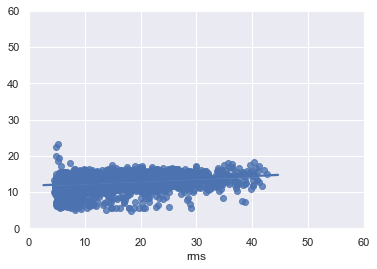

R^2 test: 0.07
RMSE test: 6.86
NSE: 0.07


In [26]:
# Predict using the linear model- on specific block data- on transect data
# x_test = 'open 3 MISR cameras that create transect block, create x_test dataset from 3 cameras (an, ca, cf), and then make prediction '
y_pred_lr = lr_model.predict(x_test)


######## plot 
import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()

sns.regplot(x=y_test, y=y_pred_lr, truncate=False, ax=ax)#, color='g')

ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
plt.show()



r2_model = r2_score(y_test, y_pred_lr)
print('R^2 test: %s' %round(r2_model,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_lr))) # square root of MSE.

# NSE
nse_lr = he.evaluator(he.nse, y_pred_lr, y_test)  # order(prediction,target)
print('NSE: %.2f' %nse_lr)


## >>> Polynomial linear regression >>>

Although this model allows for a nonlinear relationship between Y and X, polynomial regression is still considered linear regression since it is linear in the regression coefficients. it means relations of Y with respect to X is linear == degree of equation (power of X) is 1 so the relationship has power of 1

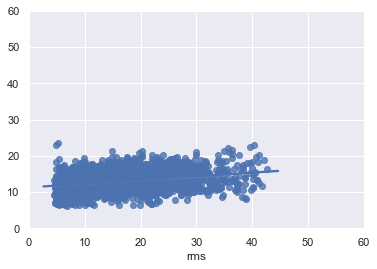

R^2 test: 0.11
RMSE test: 6.71
NSE: 0.11


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

poly_feature_matrix = PolynomialFeatures(degree=2) # how nuber of features change?
x_train_poly = poly_feature_matrix.fit_transform(x_train)

# print(x_train.shape)
# print(x_train_poly.shape) # Q- why degree= 3, 3 features turned to 20 features?

poly_linear_reg_model = LinearRegression() # build an instance of the model
# print(poly_linear_reg_model)

poly_linear_reg_model.fit(x_train_poly, y_train) # Then we fit the qlgorithm to our data/train the model
# print(poly_linear_reg_model)


x_test_poly = poly_feature_matrix.fit_transform(x_test)
y_pred_plr = poly_linear_reg_model.predict(x_test_poly) # prediction (Y^)

# print(len(y_test))
# print(len(y_pred_plr))

################################# plot data
# plt.figure(figsize=(10, 6))
# plt.title("poly regression", size=16)
# plt.scatter(y_test, y_pred_plr)
# plt.plot(y_test, y_pred_plr, c="red")
# plt.show()


import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred_plr, truncate=False, ax=ax)#, color='g')
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
plt.show()

##### R^2 score
r2_plr = r2_score(y_test, y_pred_plr)
print('R^2 test: %s' %round(r2_plr,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_plr))) # square root of MSE.

### NSE
# NSE
nse_plr = he.evaluator(he.nse, y_pred_plr, y_test)  # order(prediction,target)
print('NSE: %.2f' %nse_plr)

## >>> K-nearest neighbor >>>

In [28]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=10)

knn_model.fit(x_train, y_train) # fit algorithm to data and train it
 
# Predict on dataset which model has not seen before
y_pred_knn = knn_model.predict(x_test)

# report evaluation of mdoel performace on test data
r2_model = r2_score(y_test, y_pred_knn)
print('R^2 test: %s' %round(r2_model,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_knn))) # square root of MSE.

### NSE
nse_knn = he.evaluator(he.nse, y_pred_knn, y_test)  # order(prediction,target)
print('NSE: %.2f' %nse_knn)


R^2 test: 0.23
RMSE test: 6.23
NSE: 0.23


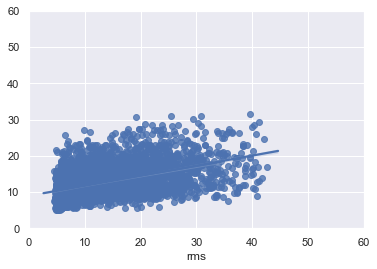

In [29]:
import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred_knn, truncate=False, ax=ax)#, color='g')
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
plt.show()

## >>> Generalized additive models (GAM) for regression >>>

In [30]:
x_train

,an,ca,cf
32655,0.296278,0.464705,0.638491
32036,0.760049,0.828614,0.885346
31523,0.940953,0.884981,0.965331
23419,0.816328,0.893935,0.906045
25676,0.269108,0.519098,0.983787
...,...,...,...
20218,0.720372,0.842699,0.989074
2324,0.720494,0.822756,0.972606
36500,0.670092,0.790781,0.825334
32176,0.765301,0.822598,0.901784


In [31]:
gam = LinearGAM(s(0) + s(1) + f(2)).fit(x_train, y_train)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1630.7873
Link Function:                     IdentityLink Log Likelihood:                                -53012.9111
Number of Samples:                        11634 AIC:                                           109289.3968
                                                AICc:                                          109822.2045
                                                GCV:                                               50.0107
                                                Scale:                                             37.5751
                                                Pseudo R-Squared:                                   0.3115
Feature Function                  Lam

/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_7742/1778368859.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [36]:
list(gam.statistics_.keys())

['n_samples',
 'm_features',
 'edof_per_coef',
 'edof',
 'scale',
 'cov',
 'se',
 'AIC',
 'AICc',
 'pseudo_r2',
 'GCV',
 'UBRE',
 'loglikelihood',
 'deviance',
 'p_values']

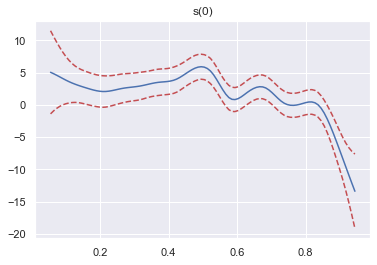

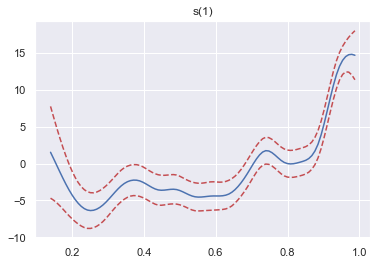

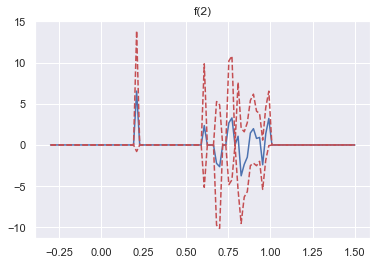

In [37]:
import matplotlib.pyplot as plt

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

## predicting a single test image block

In [32]:
# x_predict_3cams = 'build this df from 3 cameras of the image block'


In [33]:
# y_pred_block = mlr_model.predict(x_predict_3cams)


In [34]:
# visualize the predicted image
# plot the transect



In [35]:
# extract data along transect and plot R^2 fro transect

